# Kyle, Joe, Mark: Milestone 4, Pre-Trained Network

Our pre-trained network is a variation on the VGG16, a 16-layer network used to good effect in the ILSVRC-2014 competition. Details can be found in:

Very Deep Convolutional Networks for Large-Scale Image Recognition
K. Simonyan, A. Zisserman
arXiv:1409.1556

Weights are pre-trained on ImageNet, our input is specified to the same 300x185x3 size we used in our own model, and the same loss function is used to compare the two. Fully connected layers are added at the end to specify our 7 desired output labels.

Maximum binary accuracy approached 80% but this was possible by the model returning entirely 0 for its predictions. This model did not perform as well as our own deep network but will continue to be refined as a comparison deep learning method for our final paper.

In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
from scipy import ndimage

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load data
%cd ~/data/
labs = pd.read_csv('multilabels.csv')
ids = pd.read_csv('features_V1.csv', usecols=[0])

# Take care of some weirdness that led to duplicate entries
labs = pd.concat([ids,labs], axis=1, ignore_index=True)
labs = labs.drop_duplicates(subset=[0])

ids = labs.pop(0).as_matrix()
labs = labs.as_matrix()

/home/ubuntu/data


In [3]:
# Split train/test - 15k is about the limit of what we can hold in memory (12GB on Tesla K80)
n_train = 1000
n_test = 500

rnd_ids = np.random.choice(np.squeeze(ids), size=n_train+n_test, replace=False)
train_ids = rnd_ids[:n_train]
test_ids = rnd_ids[n_train:]

# Pull in multilabels
y_train = labs[np.nonzero(np.in1d(np.squeeze(ids),train_ids))[0]]
y_test = labs[np.nonzero(np.in1d(np.squeeze(ids),test_ids))[0]]



# Read in images - need to do some goofy stuff here to handle the highly irregular image sizes and formats
X_train = np.zeros([n_train, 600, 185, 3])
ct = 0
for i in train_ids:
    IM = ndimage.imread('posters/{}.jpg'.format(i))
    try:
        X_train[ct,:IM.shape[0],:,:] = IM[:,:,:3]
    except:
        X_train[ct,:IM.shape[0],:,0] = IM
    ct += 1
    if ct % 100 == 0:
        print 'training data {i}/{n} loaded'.format(i=ct, n=n_train)
X_train = X_train[:,:300,:,:] # trim excess off edges
print 'training data loaded'


X_test = np.zeros([n_test, 600, 185, 3])
ct = 0
for i in test_ids:
    IM = ndimage.imread('posters/{}.jpg'.format(i))
    try:
        X_test[ct,:IM.shape[0],:,:] = IM[:,:,:3]
    except:
        X_test[ct,:IM.shape[0],:,0] = IM
    ct += 1
    if ct % 100 == 0:
        print 'test data {i}/{n} loaded'.format(i=ct, n=n_test)
X_test = X_test[:,:300,:,:] # trim excess off edges
print 'test data loaded'

# Create dataGenerator to feed image batches - 
# this is nice because it also standardizes training data
datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True)


# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

training data 100/1000 loaded
training data 200/1000 loaded
training data 300/1000 loaded
training data 400/1000 loaded
training data 500/1000 loaded
training data 600/1000 loaded
training data 700/1000 loaded
training data 800/1000 loaded
training data 900/1000 loaded
training data 1000/1000 loaded
training data loaded
test data 100/500 loaded
test data 200/500 loaded
test data 300/500 loaded
test data 400/500 loaded
test data 500/500 loaded
test data loaded


In [4]:
# Generate a model based on the VGG16 model
# code adapted from https://github.com/fchollet/keras/issues/4465
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

#Create your own input format
input = Input(shape=(300,185,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

#Add fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(7, activation='sigmoid', name='predictions')(x)

#Create your own model 
my_model = Model(input=input, output=x)

my_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['binary_accuracy'])

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("im...)`


In [5]:
# Fit the model with a first round of training data
my_model.fit_generator(datagen.flow(X_train, y_train, batch_size=25),
                    steps_per_epoch=len(X_train) / 25, epochs=5)

Epoch 1/5
40/40 [==============================] - 81s - loss: 3.2782 - binary_accuracy: 0.7830      

In [6]:
score = my_model.evaluate(X_test, y_test, batch_size=50)

500/500 [==============================] - 16s     


In [8]:
score

[3.329537844657898, 0.79342855811119084]

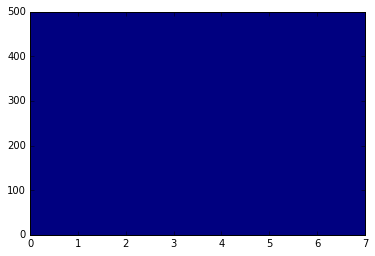

In [10]:
plt.pcolor(my_model.predict(X_test))

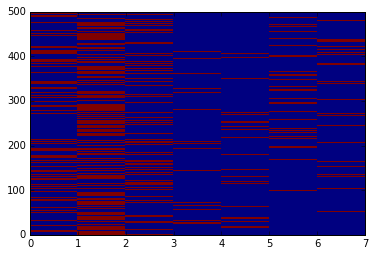

In [11]:
plt.pcolor(y_test)

In [13]:
# Draw a new train/test sample, a little bigger this time
n_train = 5000
n_test = 1000

rnd_ids = np.random.choice(np.squeeze(ids), size=n_train+n_test, replace=False)
train_ids = rnd_ids[:n_train]
test_ids = rnd_ids[n_train:]

# Pull in multilabels
y_train = labs[np.nonzero(np.in1d(np.squeeze(ids),train_ids))[0]]
y_test = labs[np.nonzero(np.in1d(np.squeeze(ids),test_ids))[0]]



# Read in images - need to do some goofy stuff here to handle the highly irregular image sizes and formats
X_train = np.zeros([n_train, 600, 185, 3])
ct = 0
for i in train_ids:
    IM = ndimage.imread('posters/{}.jpg'.format(i))
    try:
        X_train[ct,:IM.shape[0],:,:] = IM[:,:,:3]
    except:
        X_train[ct,:IM.shape[0],:,0] = IM
    ct += 1
    if ct % 100 == 0:
        print 'training data {i}/{n} loaded'.format(i=ct, n=n_train)
X_train = X_train[:,:300,:,:] # trim excess off edges
print 'training data loaded'


X_test = np.zeros([n_test, 600, 185, 3])
ct = 0
for i in test_ids:
    IM = ndimage.imread('posters/{}.jpg'.format(i))
    try:
        X_test[ct,:IM.shape[0],:,:] = IM[:,:,:3]
    except:
        X_test[ct,:IM.shape[0],:,0] = IM
    ct += 1
    if ct % 100 == 0:
        print 'test data {i}/{n} loaded'.format(i=ct, n=n_test)
X_test = X_test[:,:300,:,:] # trim excess off edges
print 'test data loaded'

# Create dataGenerator to feed image batches - 
# this is nice because it also standardizes training data
datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True)


# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

training data 100/5000 loaded
training data 200/5000 loaded
training data 300/5000 loaded
training data 400/5000 loaded
training data 500/5000 loaded
training data 600/5000 loaded
training data 700/5000 loaded
training data 800/5000 loaded
training data 900/5000 loaded
training data 1000/5000 loaded
training data 1100/5000 loaded
training data 1200/5000 loaded
training data 1300/5000 loaded
training data 1400/5000 loaded
training data 1500/5000 loaded
training data 1600/5000 loaded
training data 1700/5000 loaded
training data 1800/5000 loaded
training data 1900/5000 loaded
training data 2000/5000 loaded
training data 2100/5000 loaded
training data 2200/5000 loaded
training data 2300/5000 loaded
training data 2400/5000 loaded
training data 2500/5000 loaded
training data 2600/5000 loaded
training data 2700/5000 loaded
training data 2800/5000 loaded
training data 2900/5000 loaded
training data 3000/5000 loaded
training data 3100/5000 loaded
training data 3200/5000 loaded
training data 330

In [ ]:
# more training
my_model.fit_generator(datagen.flow(X_train, y_train, batch_size=25),
                    steps_per_epoch=len(X_train) / 25, epochs=5)

Epoch 1/5
 19/200 [=>............................] - ETA: 336s - loss: 3.4030 - binary_accuracy: 0.7889